## 1- Creating weighted-directed graphs

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
nodes_df = pd.read_csv('nodes.csv')
# Load the edges.csv file into a DataFrame
edges_df = pd.read_csv('edges.csv')

def create_graph(nodes_df, edges_df, migration_year):
    graph = nx.DiGraph()

    # Add nodes
    for index, row in nodes_df.iterrows():
        graph.add_node(row['Label'], name=row['Abb'])

    # Add edges with weights and attributes for the specific year
    for index, row in edges_df.iterrows():
        source = row['source']
        target = row['target']
        weight = row[migration_year]
        if weight != 0:
            female_ratio = row[migration_year.replace('total', 'female')] / weight
        else:
            female_ratio = 0
        graph.add_edge(source, target, weight=weight, female_ratio=female_ratio)

    # Clean up the graph (removing low weight edges and isolated nodes)
    remove_low_weight_edges(graph, 50000)
    remove_isolated_nodes(graph)
    return graph

def visualize_graph(graph, nodes_df, title):
    node_sizes = [graph.in_degree(n, weight='weight')/20000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 500000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels(graph, nodes_df)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color='red', alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()

def remove_low_weight_edges(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold]
    graph.remove_edges_from(edges_to_remove)

def remove_isolated_nodes(graph):
    nodes_to_remove = [n for n in graph.nodes() if graph.degree(n) == 0]
    graph.remove_nodes_from(nodes_to_remove)

def get_high_degree_labels(graph, nodes_df):
    return {n: data['Abb'] for n, data in nodes_df.set_index('Label').iterrows() 
            if n in graph.nodes() and (graph.in_degree(n, weight='weight') > 500000 or graph.out_degree(n, weight='weight') > 1000000)}

# Main execution loop for each migration year
migration_years = ['migration_1990_total', 'migration_1995_total', 'migration_2000_total', 'migration_2005_total', 'migration_2010_total', 'migration_2015_total']
graphs =[]
for year in migration_years:
    # Create a separate graph for each year and store it in a dictionary
    graph = create_graph(nodes_df, edges_df, year)
    # Visualize the graph
    # visualize_graph(graph, nodes_df, year)
    graphs.append(graph)

## 2- Community Detection (Louvain method - For undirected graphs):

In [20]:
import community as community_louvain

# Position, size, and labels
node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graphs[0].nodes}
node_sizes = [graphs[0].degree(n, weight='weight')/20000 for n in graphs[0].nodes()]
labels = get_high_degree_labels(graphs[0], nodes_df)

edge_weights = [d['weight'] / 500000 for _, _, d in graphs[0].edges(data=True)]
# edge_colors = [cmap(partition[u]) for u, v, d in graphs[0].edges(data=True)]

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\3724723826.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(community_colors) + 1)


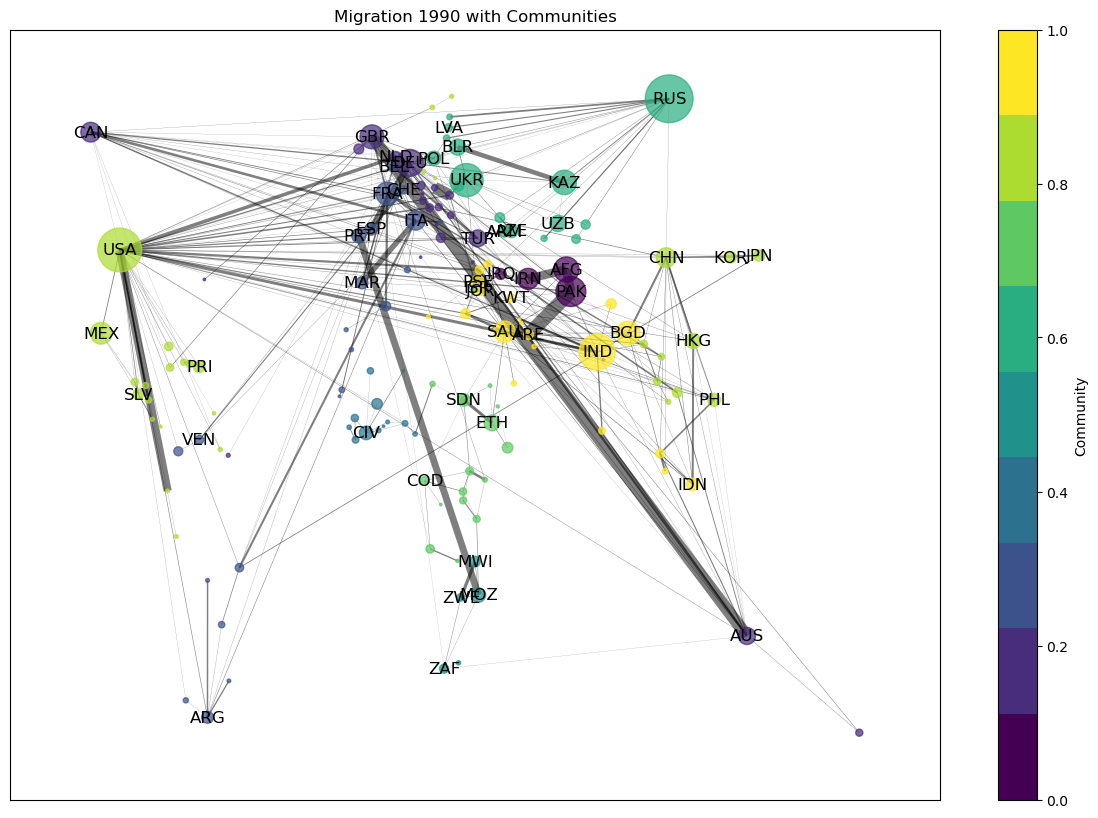

In [21]:
# Convert the graph to an undirected graph
graphs_0_undirected = graphs[0].to_undirected()

# Applying the Louvain method for community detection in the first graph
partition = community_louvain.best_partition(graphs_0_undirected, weight='weight')

# Adding community information to the nodes for visualization for the first graph
for node in graphs_0_undirected.nodes:
    graphs_0_undirected.nodes[node]['community'] = partition[node]

# Using a color map to distinguish different communities
community_colors = [partition[node] for node in graphs_0_undirected.nodes]
cmap = plt.cm.get_cmap('viridis', max(community_colors) + 1)

# Visualizing the graph with community information
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(graphs_0_undirected, node_positions, node_size=node_sizes, node_color=community_colors, cmap=cmap, alpha=0.7)
nx.draw_networkx_edges(graphs_0_undirected, node_positions, width=edge_weights, alpha=0.5)
nx.draw_networkx_labels(graphs_0_undirected, node_positions, labels=labels, font_size=12)
plt.title('Migration 1990 with Communities')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical', label='Community')
plt.show()


### 2-1. Creating subgraphs using the detected communities

In [22]:
# Inverting the partition to group nodes by community
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

# Creating a subgraph for each community
subgraphs = []
for community in communities:
    subgraph = graphs_0_undirected.subgraph(communities[community])
    subgraphs.append(subgraph)

In [23]:
def visualize_graph_undirected(graph, nodes_df, title):
    node_sizes = [graph.degree(n, weight='weight')/10000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 100000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels_undirected(graph, nodes_df)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color='red', alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()

def get_high_degree_labels_undirected(graph, nodes_df):
    return {n: data['Abb'] for n, data in nodes_df.set_index('Label').iterrows() 
            if n in graph.nodes() and (graph.degree(n, weight='weight') > 1000)}

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\2405210408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_0['community'] = 0


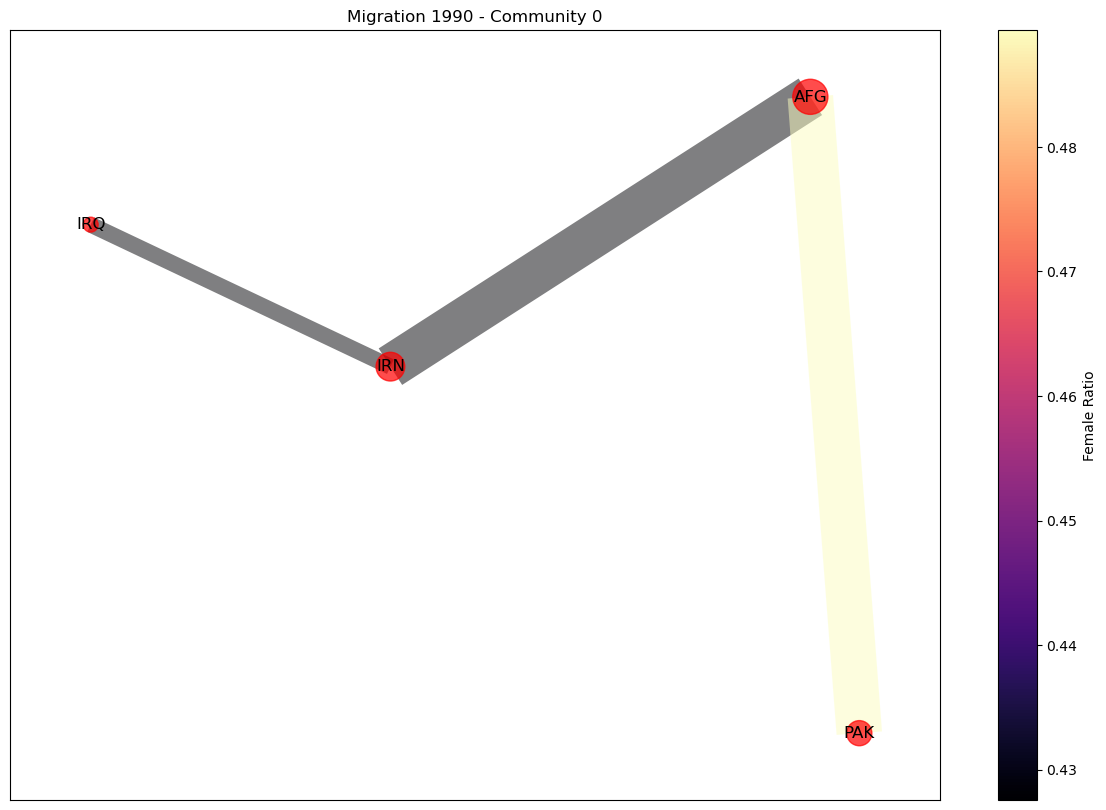

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\2405210408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_0['weight'] = [subgraphs[0].degree(n, weight='weight') for n in subgraphs[0].nodes()]


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community,weight
0,0,Afghanistan,4,Asia,Southern Asia,"array([1.83174148, 1.86242262])",33.939110,67.709953,AFG,0,6400641
99,99,Iran (Islamic Republic of),364,Asia,Southern Asia,"array([1.78486421, 1.89879802])",32.427908,53.688046,IRN,0,4277937
100,100,Iraq,368,Asia,Western Asia,"array([1.89757756, 1.93435699])",33.223191,43.679291,IRQ,0,1153969
155,155,Pakistan,586,Asia,Southern Asia,"array([1.84295684, 2.03866266])",30.375321,69.345116,PAK,0,3276673


In [24]:
# printing the nodes of the first subgraph using the nodes attribute abbreviation
subgraphs[0].nodes(data=True)
# Storing the names of the nodes in the first subgraph in a list
subgraph_nodes_0 = [data['name'] for node, data in subgraphs[0].nodes(data=True)]

# Creating a DataFrame of the nodes in the first subgraph
subgraph_nodes_df_0 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_0)]
# adding the community information to the DataFrame
subgraph_nodes_df_0['community'] = 0

# visualizing the first subgraph
visualize_graph_undirected(subgraphs[0], subgraph_nodes_df_0, 'Migration 1990 - Community 0')

# adding the weights of the nodes in the first subgraph to the dataframe
subgraph_nodes_df_0['weight'] = [subgraphs[0].degree(n, weight='weight') for n in subgraphs[0].nodes()]
# sorting the DataFrame by the weight of the nodes
subgraph_nodes_df_0.sort_values(by='weight', ascending=False)

subgraph_nodes_df_0


In [25]:
# dropping columns "Label" and "_pos" , index, "lat", "lng" from the DataFrame
subgraph_nodes_df_0.drop(columns=['Label', '_pos', 'lat', 'lng', 'code'], inplace=True)

# saving the DataFrame as a csv file
subgraph_nodes_df_0.to_csv('comm0.csv', index=False)

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\1088305272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_0.drop(columns=['Label', '_pos', 'lat', 'lng', 'code'], inplace=True)


In [26]:
# printing the nodes of the second subgraph using the nodes attribute abbreviation
subgraphs[1].nodes(data=True)
# Storing the names of the nodes in the second subgraph in a list
subgraph_nodes_1 = [data['name'] for node, data in subgraphs[1].nodes(data=True)]

# Creating a DataFrame of the nodes in the second subgraph
subgraph_nodes_df_1 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_1)]
# adding the community information to the DataFrame
subgraph_nodes_df_1['community'] = 1

# adding the weights of the nodes in the first subgraph to the dataframe
subgraph_nodes_df_1['weight'] = [subgraphs[1].degree(n, weight='weight') for n in subgraphs[1].nodes()]
# sorting the DataFrame by the weight of the nodes
subgraph_nodes_df_1.sort_values(by='weight', ascending=False)

subgraph_nodes_df_1

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\316828556.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_1['community'] = 1
C:\Users\PA\AppData\Local\Temp\ipykernel_5320\316828556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_1['weight'] = [subgraphs[1].degree(n, weight='weight') for n in subgraphs[1].nodes()]


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community,weight
1,1,Albania,8,Europe,Southern Europe,"array([1.89105956, 2.05459683])",41.153332,20.168331,ALB,1,63963
11,11,Australia,36,Oceania,Australia and New Zealand,"array([1.84918437, 2.00546947])",-25.274398,133.775136,AUS,1,1898326
12,12,Austria,40,Europe,Western Europe,"array([1.83979734, 1.9617719 ])",47.516231,14.550072,AUT,1,388795
22,22,Bermuda,60,Northern America,South America,"array([1.76429943, 2.06958287])",32.321384,-64.757370,BMU,1,642036
26,26,Bosnia and Herzegovina,70,Europe,Southern Europe,"array([1.91284333, 2.01372877])",43.915886,17.679076,BIH,1,526198
31,31,Bulgaria,100,Europe,Eastern Europe,"array([1.8386259 , 1.94852143])",42.733883,25.485830,BGR,1,61457
37,37,Canada,124,Northern America,South America,"array([1.80817934, 1.99441469])",56.130366,-106.346771,CAN,1,584189
41,41,Channel Islands,830,Europe,Northern Europe,"array([1.83638439, 2.22189626])",19.333000,81.217000,CIN,1,462767
52,52,Croatia,191,Europe,Southern Europe,"array([1.88729378, 1.96674039])",45.100000,15.200000,HRV,1,1121276
55,55,Cyprus,196,Asia,Western Asia,"array([1.8602191 , 1.93974762])",35.126413,33.429859,CYP,1,54519


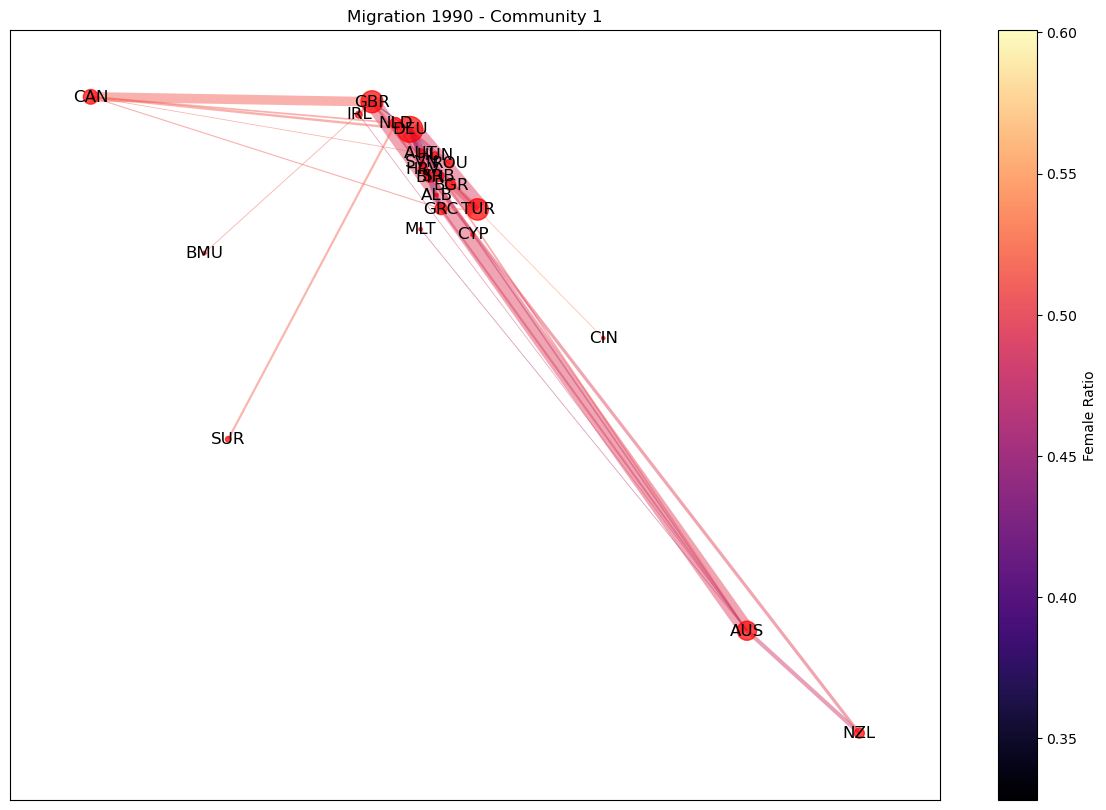

In [27]:
# visualizing the second subgraph
visualize_graph_undirected(subgraphs[1], subgraph_nodes_df_1, 'Migration 1990 - Community 1')

In [28]:
# dropping columns "Label" and "_pos" , index, "lat", "lng" from the DataFrame
subgraph_nodes_df_1.drop(columns=['Label', '_pos', 'lat', 'lng', 'code'], inplace=True)

# saving the DataFrame as a csv file
subgraph_nodes_df_1.to_csv('comm1.csv', index=False)

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\4193289989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_1.drop(columns=['Label', '_pos', 'lat', 'lng', 'code'], inplace=True)


In [29]:
# printing the nodes of the third subgraph using the nodes attribute abbreviation
subgraphs[2].nodes(data=True)
# Storing the names of the nodes in the third subgraph in a list
subgraph_nodes_2 = [data['name'] for node, data in subgraphs[2].nodes(data=True)]

# Creating a DataFrame of the nodes in the third subgraph
subgraph_nodes_df_2 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_2)]
# adding the community information to the DataFrame
subgraph_nodes_df_2['community'] = 2

# adding the weights of the nodes in the first subgraph to the dataframe
subgraph_nodes_df_2['weight'] = [subgraphs[2].degree(n, weight='weight') for n in subgraphs[2].nodes()]
# sorting the DataFrame by the weight of the nodes
subgraph_nodes_df_2.sort_values(by='weight', ascending=False)

subgraph_nodes_df_2

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\586578442.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_2['community'] = 2
C:\Users\PA\AppData\Local\Temp\ipykernel_5320\586578442.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_2['weight'] = [subgraphs[2].degree(n, weight='weight') for n in subgraphs[2].nodes()]


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community,weight
2,2,Algeria,12,Africa,Northern Africa,"array([1.90130528, 1.98917661])",28.033886,1.659626,DZA,2,956819
8,8,Argentina,32,Latin America and the Caribbean,South America,"array([1.78741413, 1.9813161 ])",-38.416097,-63.616672,ARG,2,94138
19,19,Belgium,56,Europe,Western Europe,"array([1.86513634, 1.95633179])",50.503887,4.469936,BEL,2,1330486
24,24,Bolivia (Plurinational State of),68,Latin America and the Caribbean,South America,"array([1.80487629, 1.9795185 ])",-16.290154,-63.588653,BOL,2,1152035
28,28,Brazil,76,Latin America and the Caribbean,South America,"array([1.79691048, 1.96465094])",-14.235004,-51.925280,BRA,2,519007
42,42,Chile,152,Latin America and the Caribbean,South America,"array([1.81695556, 1.9859948 ])",-35.675147,-71.542969,CHL,2,147234
46,46,Colombia,170,Latin America and the Caribbean,South America,"array([1.77265212, 1.995916 ])",4.570868,-74.297333,COL,2,515548
74,74,France,250,Europe,Western Europe,"array([1.83726869, 1.99911738])",46.227638,2.213749,FRA,2,368598
78,78,Gambia,270,Africa,Western Africa,"array([1.86830996, 1.80561622])",13.443182,-15.310139,GMB,2,1217464
104,104,Italy,380,Europe,Southern Europe,"array([1.85659895, 1.98213119])",41.871940,12.567380,ITA,2,223528


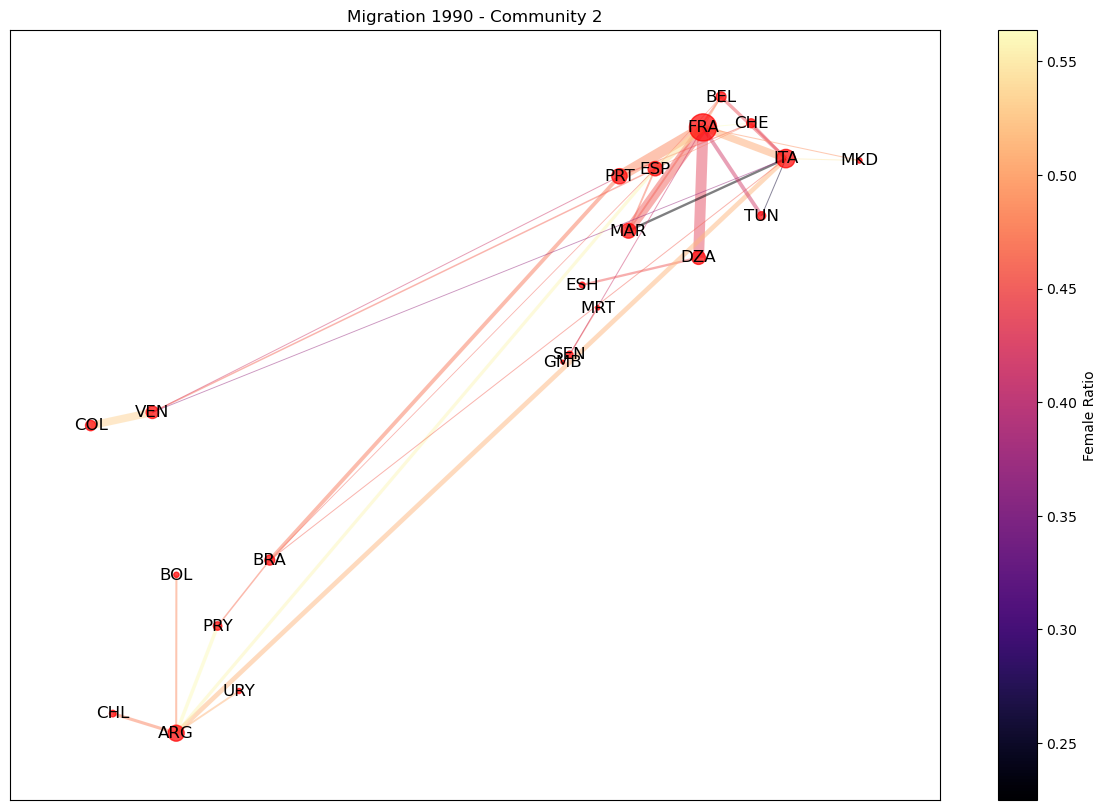

In [30]:
# visualizing the third subgraph
visualize_graph_undirected(subgraphs[2], subgraph_nodes_df_2, 'Migration 1990 - Community 2')

In [31]:
# dropping columns "Label" and "_pos" , index, "lat", "lng" from the DataFrame
subgraph_nodes_df_2.drop(columns=['Label', '_pos', 'lat', 'lng', 'code'], inplace=True)

# saving the DataFrame as a csv file
subgraph_nodes_df_2.to_csv('comm2.csv', index=False)

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\3589572645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_2.drop(columns=['Label', '_pos', 'lat', 'lng', 'code'], inplace=True)


In [32]:
# printing the nodes of the fourth subgraph using the nodes attribute abbreviation
subgraphs[3].nodes(data=True)
# Storing the names of the nodes in the fourth subgraph in a list
subgraph_nodes_3 = [data['name'] for node, data in subgraphs[3].nodes(data=True)]

# Creating a DataFrame of the nodes in the fourth subgraph
subgraph_nodes_df_3 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_3)]
# adding the community information to the DataFrame
subgraph_nodes_df_3['community'] = 3



subgraph_nodes_df_3

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\1231238276.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_3['community'] = 3


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community
5,5,Angola,24,Africa,Middle Africa,"array([1.9465887, 1.9502161])",-11.202692,17.873887,AGO,3
33,33,Burundi,108,Africa,Eastern Africa,"array([1.99418069, 1.94910222])",-3.373056,29.918886,BDI,3
40,40,Chad,148,Africa,Middle Africa,"array([1.89290505, 1.81754963])",15.454166,18.732207,TCD,3
48,48,Congo,178,Africa,Middle Africa,"array([1.92557436, 1.8872231 ])",-4.038333,21.758664,COG,3
58,58,Democratic Republic of the Congo,180,Africa,Middle Africa,"array([1.95870703, 1.91501136])",-0.228021,15.827659,COD,3
60,60,Djibouti,262,Africa,Eastern Africa,"array([1.81580121, 1.80983071])",11.825138,42.590275,DJI,3
67,67,Eritrea,232,Africa,Eastern Africa,"array([1.9686361 , 1.93768343])",15.179384,39.782334,ERI,3
69,69,Ethiopia,231,Africa,Eastern Africa,"array([1.92490949, 1.93707557])",9.145000,40.489673,ETH,3
109,109,Kenya,404,Africa,Eastern Africa,"array([1.94474334, 1.98251715])",-0.023559,37.906193,KEN,3
171,171,Rwanda,646,Africa,Eastern Africa,"array([1.9849483 , 1.97177015])",-1.940278,29.873888,RWA,3


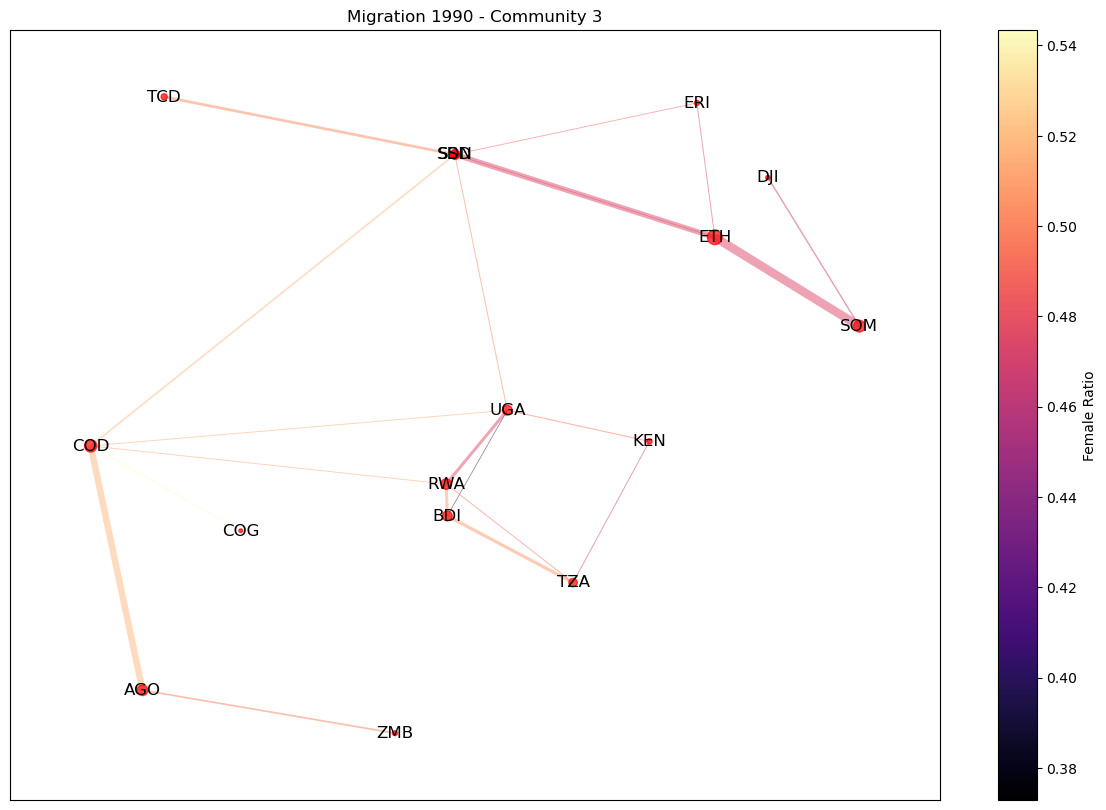

In [33]:
# visualizing the fourth subgraph
visualize_graph_undirected(subgraphs[3], subgraph_nodes_df_3, 'Migration 1990 - Community 3')

In [34]:
# printing the nodes of the fifth subgraph using the nodes attribute abbreviation
subgraphs[4].nodes(data=True)
# Storing the names of the nodes in the fifth subgraph in a list
subgraph_nodes_4 = [data['name'] for node, data in subgraphs[4].nodes(data=True)]

# Creating a DataFrame of the nodes in the fifth subgraph
subgraph_nodes_df_4 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_4)]
# adding the community information to the DataFrame
subgraph_nodes_df_4['community'] = 4

subgraph_nodes_df_4

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\2021754608.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_4['community'] = 4


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community
9,9,Armenia,51,Asia,Western Asia,"array([1.77097526, 1.86287605])",40.069099,45.038189,ARM,4
13,13,Azerbaijan,31,Asia,Western Asia,"array([1.77487777, 1.82943961])",40.143105,47.576927,AZE,4
18,18,Belarus,112,Europe,Eastern Europe,"array([1.78801017, 1.88038013])",53.709807,27.953389,BLR,4
68,68,Estonia,233,Europe,Northern Europe,"array([1.80039032, 1.94975273])",58.595272,25.013607,EST,4
79,79,Georgia,268,Asia,Western Asia,"array([1.72260057, 1.89020488])",42.315407,43.356892,GEO,4
103,103,Israel,376,Asia,Western Asia,"array([1.76655309, 1.92871435])",31.046051,34.851612,ISR,4
108,108,Kazakhstan,398,Asia,Central Asia,"array([1.75499183, 1.87702964])",48.019573,66.923684,KAZ,4
112,112,Kyrgyzstan,417,Asia,Central Asia,"array([1.73332032, 1.87168287])",41.204380,74.766098,KGZ,4
114,114,Latvia,428,Europe,Northern Europe,"array([1.81697774, 1.91983731])",56.879635,24.603189,LVA,4
120,120,Lithuania,440,Europe,Northern Europe,"array([1.76231228, 1.91316052])",55.169438,23.881275,LTU,4


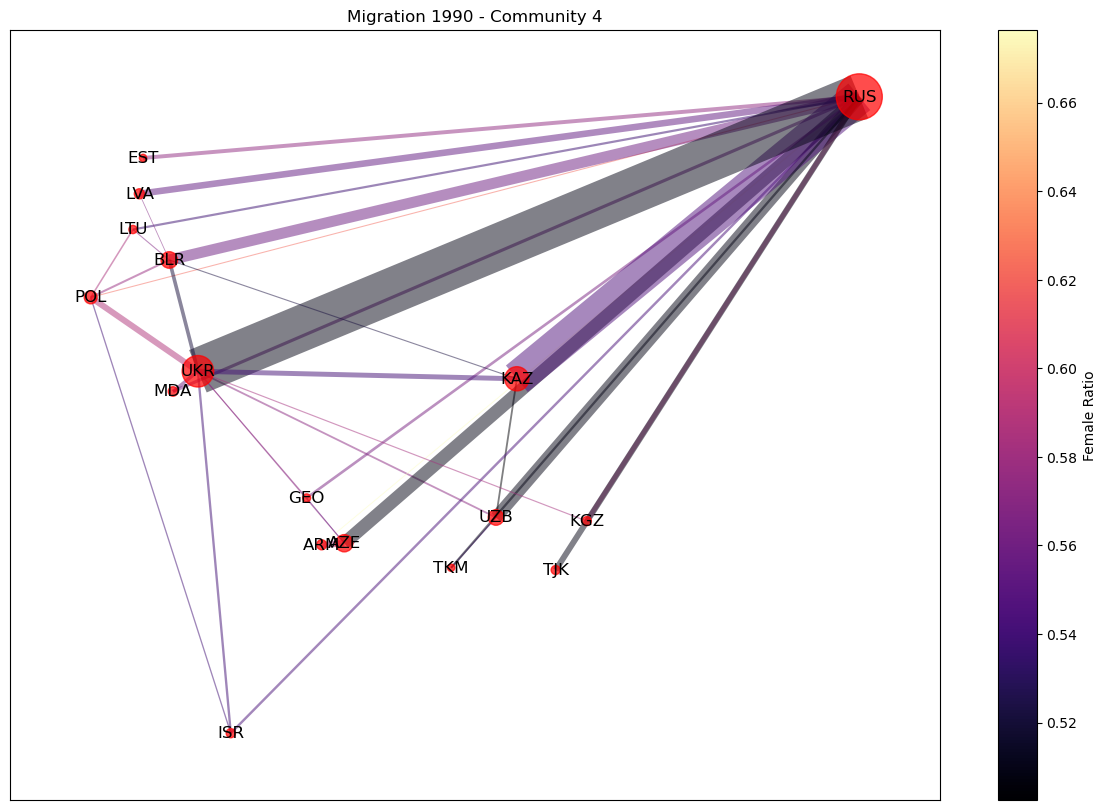

In [35]:
# visualizing the fifth subgraph
visualize_graph_undirected(subgraphs[4], subgraph_nodes_df_4, 'Migration 1990 - Community 4')

In [36]:
# printing the nodes of the sixth subgraph using the nodes attribute abbreviation
subgraphs[5].nodes(data=True)
# Storing the names of the nodes in the sixth subgraph in a list
subgraph_nodes_5 = [data['name'] for node, data in subgraphs[5].nodes(data=True)]

# Creating a DataFrame of the nodes in the sixth subgraph
subgraph_nodes_df_5 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_5)]

# adding the community information to the DataFrame
subgraph_nodes_df_5['community'] = 5

subgraph_nodes_df_5

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\4227816963.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_5['community'] = 5


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community
15,15,Bahrain,48,Asia,Western Asia,"array([1.92645288, 1.95643674])",25.930414,50.637772,BHR,5
16,16,Bangladesh,50,Asia,Southern Asia,"array([1.86621049, 2.05299172])",23.684994,90.356331,BGD,5
64,64,Egypt,818,Africa,Northern Africa,"array([1.85439876, 1.92223817])",26.820553,30.802498,EGY,5
97,97,India,356,Asia,Southern Asia,"array([1.8306832 , 2.02026528])",20.593684,78.962880,IND,5
98,98,Indonesia,360,Asia,South-Eastern Asia,"array([1.82751849, 2.0505267 ])",-0.789275,113.921327,IDN,5
107,107,Jordan,400,Asia,Western Asia,"array([1.87836486, 1.93368856])",30.585164,36.238414,JOR,5
111,111,Kuwait,414,Asia,Western Asia,"array([1.87634793, 1.88479147])",29.311660,47.481766,KWT,5
115,115,Lebanon,422,Asia,Western Asia,"array([1.78187815, 1.92153111])",33.854721,35.862285,LBN,5
118,118,Libya,434,Africa,Northern Africa,"array([1.86082718, 1.90332594])",26.335100,17.228331,LBY,5
124,124,Malaysia,458,Asia,South-Eastern Asia,"array([1.83272346, 2.07159775])",4.210484,101.975766,MYS,5


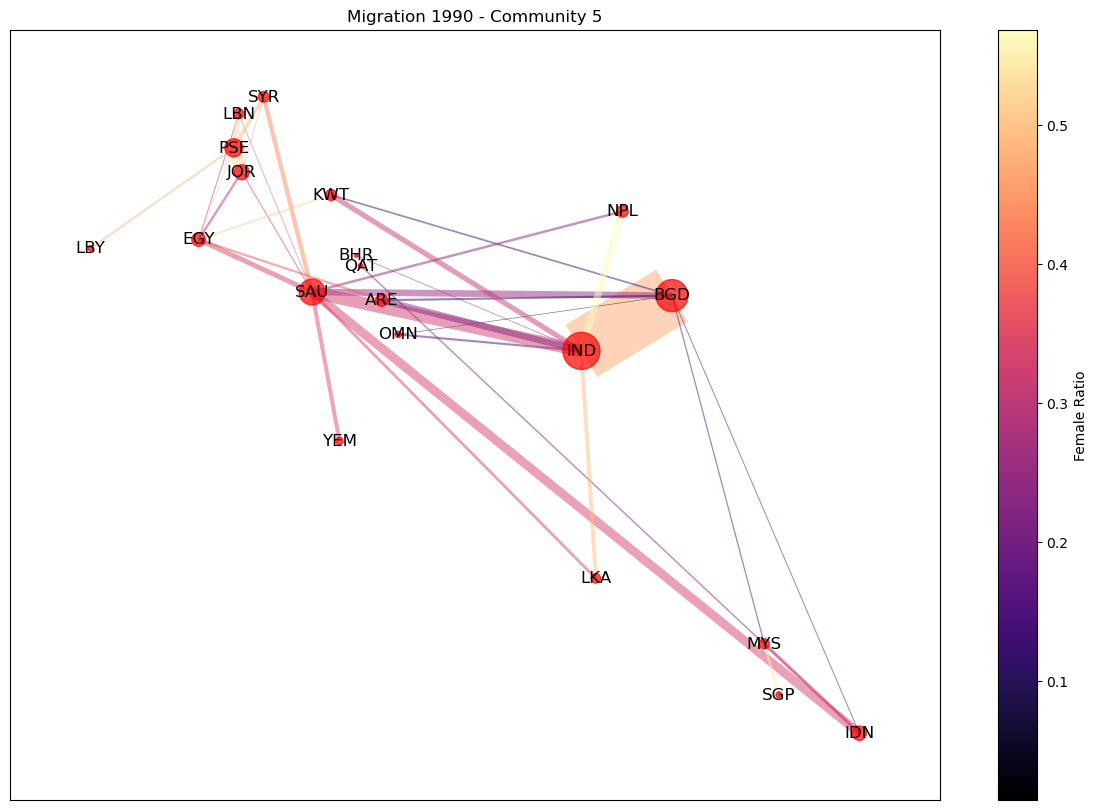

In [37]:
# visualizing the sixth subgraph
visualize_graph_undirected(subgraphs[5], subgraph_nodes_df_5, 'Migration 1990 - Community 5')

In [38]:
# printing the nodes of the seventh subgraph using the nodes attribute abbreviation
subgraphs[6].nodes(data=True)
# Storing the names of the nodes in the seventh subgraph in a list
subgraph_nodes_6 = [data['name'] for node, data in subgraphs[6].nodes(data=True)]

# Creating a DataFrame of the nodes in the seventh subgraph
subgraph_nodes_df_6 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_6)]
# adding the community information to the DataFrame
subgraph_nodes_df_6['community'] = 6

subgraph_nodes_df_6

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\3322020050.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_6['community'] = 6


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community
21,21,Benin,204,Africa,Western Africa,"array([1.93530374, 1.84289563])",9.307690,2.315834,BEN,6
32,32,Burkina Faso,854,Africa,Western Africa,"array([1.8428376 , 1.80209088])",12.238333,-1.561593,BFA,6
36,36,Cameroon,120,Africa,Middle Africa,"array([1.90366504, 1.87706999])",7.369722,12.354722,CMR,6
51,51,Côte d'Ivoire,384,Africa,Western Africa,"array([1.93302742, 1.86678355])",7.539989,-5.547080,CIV,6
81,81,Ghana,288,Africa,Western Africa,"array([1.89124081, 1.91463084])",7.946527,-1.023194,GHA,6
89,89,Guinea,324,Africa,Western Africa,"array([1.85236838, 1.86381327])",9.945587,-9.696645,GIN,6
117,117,Liberia,430,Africa,Western Africa,"array([1.8905502 , 1.86264086])",6.428055,-9.429499,LBR,6
126,126,Mali,466,Africa,Western Africa,"array([1.91312593, 1.85400889])",17.570692,-3.996166,MLI,6
149,149,Niger,562,Africa,Western Africa,"array([1.84852129, 1.82356369])",17.607789,8.081666,NER,6
150,150,Nigeria,566,Africa,Western Africa,"array([1.83303626, 1.88668369])",9.081999,8.675277,NGA,6


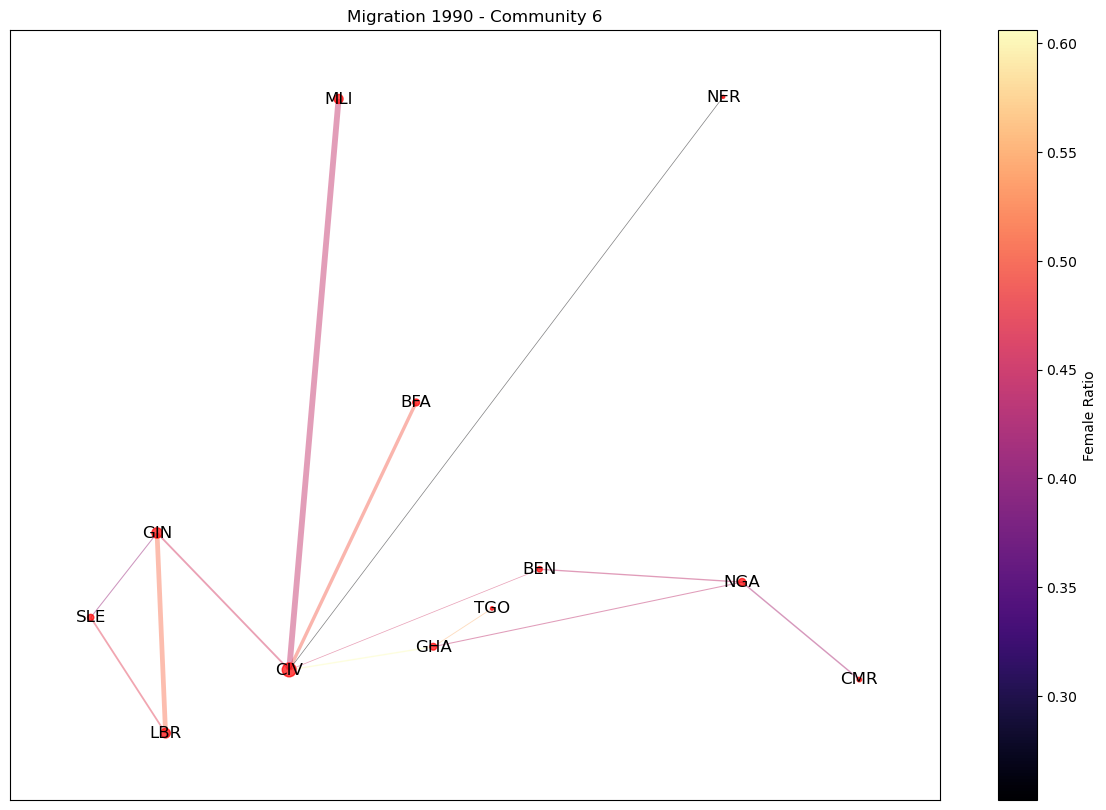

In [39]:
# visualizing the seventh subgraph
visualize_graph_undirected(subgraphs[6], subgraph_nodes_df_6, 'Migration 1990 - Community 6')

In [40]:
# printing the nodes of the eighth subgraph using the nodes attribute abbreviation
subgraphs[7].nodes(data=True)
# Storing the names of the nodes in the eighth subgraph in a list
subgraph_nodes_7 = [data['name'] for node, data in subgraphs[7].nodes(data=True)]

# Creating a DataFrame of the nodes in the eighth subgraph
subgraph_nodes_df_7 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_7)]
# adding the community information to the DataFrame
subgraph_nodes_df_7['community'] = 7

subgraph_nodes_df_7

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\715570703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_7['community'] = 7


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community
35,35,Cambodia,116,Asia,South-Eastern Asia,"array([1.86276584, 2.07425401])",12.565679,104.990963,KHM,7
43,43,China,156,Asia,Eastern Asia,"array([1.81634823, 2.02608907])",35.861660,104.195397,CHN,7
44,44,"China, Hong Kong Special Administrative Region",344,Asia,Eastern Asia,"array([1.80288136, 2.0861877 ])",22.396428,114.109497,HKG,7
45,45,"China, Macao Special Administrative Region",446,Asia,Eastern Asia,"array([1.77593072, 2.15239029])",22.198745,113.543873,MAC,7
50,50,Costa Rica,188,Latin America and the Caribbean,Central America,"array([1.79249528, 1.99744348])",9.748917,-83.753428,CRI,7
53,53,Cuba,192,Latin America and the Caribbean,Caribbean,"array([1.76310321, 2.01329857])",21.521757,-77.781167,CUB,7
56,56,Czech Republic,203,Europe,Eastern Europe,"array([1.86785484, 1.97305001])",49.817492,15.472962,CZE,7
62,62,Dominican Republic,214,Latin America and the Caribbean,Caribbean,"array([1.75718074, 1.98982508])",18.735693,-70.162651,DOM,7
63,63,Ecuador,218,Latin America and the Caribbean,South America,"array([1.76249727, 1.9482164 ])",-1.831239,-78.183406,ECU,7
65,65,El Salvador,222,Latin America and the Caribbean,Central America,"array([1.73101409, 1.9602583 ])",13.794185,-88.896530,SLV,7


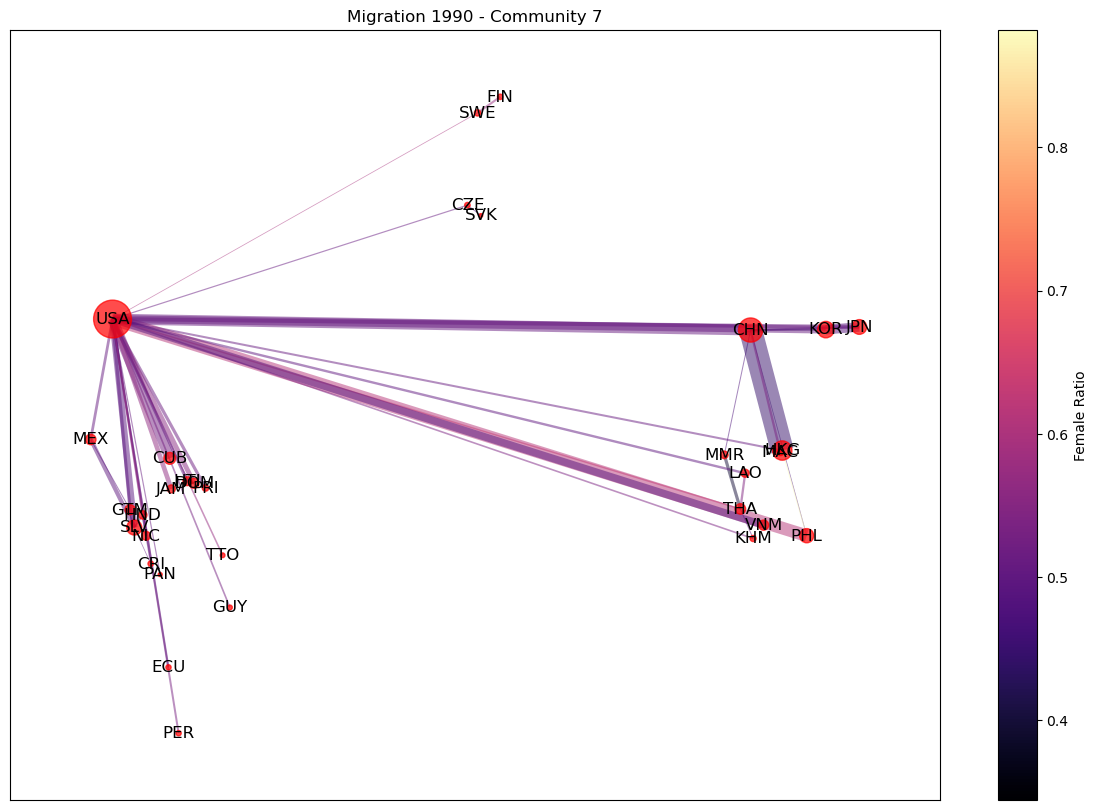

In [41]:
# visualizing the eighth subgraph
visualize_graph_undirected(subgraphs[7], subgraph_nodes_df_7, 'Migration 1990 - Community 7')

In [42]:
# printing the nodes of the ninth subgraph using the nodes attribute abbreviation
subgraphs[8].nodes(data=True)
# Storing the names of the nodes in the ninth subgraph in a list
subgraph_nodes_8 = [data['name'] for node, data in subgraphs[8].nodes(data=True)]

# Creating a DataFrame of the nodes in the ninth subgraph
subgraph_nodes_df_8 = nodes_df[nodes_df['Abb'].isin(subgraph_nodes_8)]
# adding the community information to the DataFrame
subgraph_nodes_df_8['community'] = 8

subgraph_nodes_df_8

C:\Users\PA\AppData\Local\Temp\ipykernel_5320\3914009487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgraph_nodes_df_8['community'] = 8


,Label,name,code,region,sub_region,_pos,lat,lng,Abb,community
116,116,Lesotho,426,Africa,Southern Africa,"array([1.99093658, 2.00201272])",-29.609988,28.233608,LSO,8
123,123,Malawi,454,Africa,Eastern Africa,"array([1.9775754 , 1.90287747])",-13.254308,34.301525,MWI,8
140,140,Mozambique,508,Africa,Eastern Africa,"array([1.96186846, 1.9867689 ])",-18.665695,35.529562,MOZ,8
191,191,South Africa,710,Africa,Southern Africa,"array([1.86743615, 1.99315651])",-30.559482,22.937506,ZAF,8
231,231,Zimbabwe,716,Africa,Eastern Africa,"array([1.81745367, 1.87408624])",-19.015438,29.154857,ZWE,8


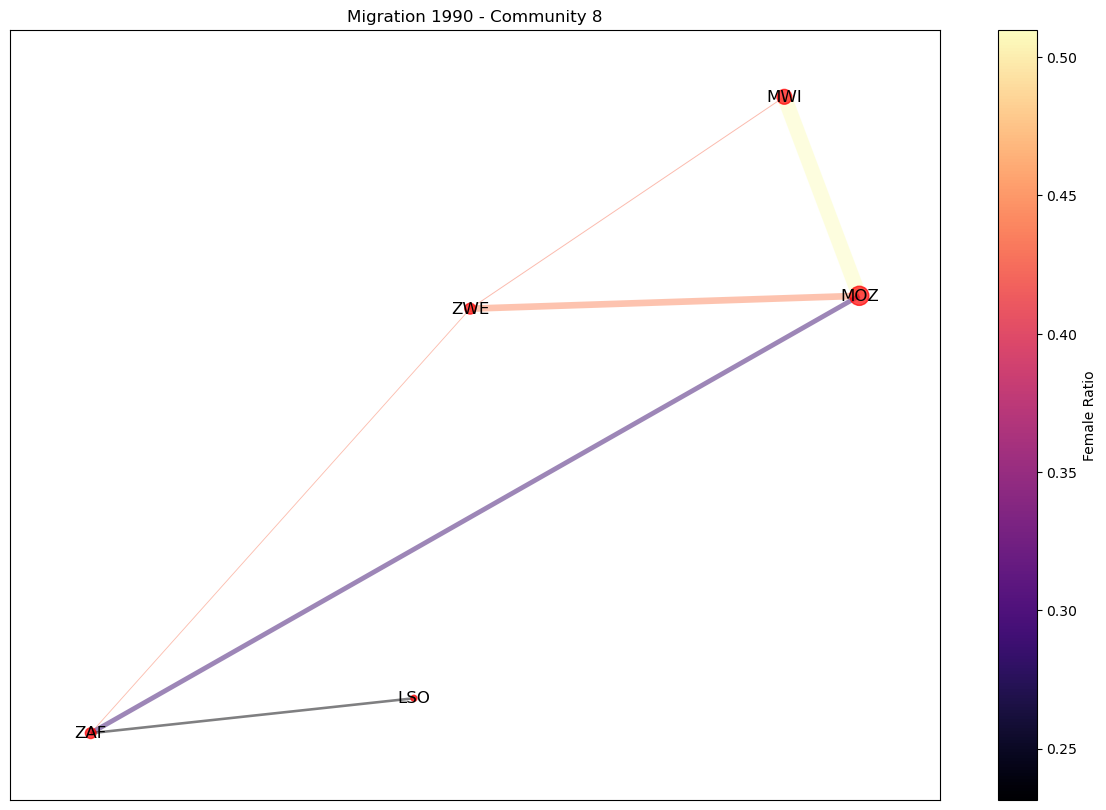

In [43]:
# visualizing the ninth subgraph
visualize_graph_undirected(subgraphs[8], subgraph_nodes_df_8, 'Migration 1990 - Community 8')

## 3. Visualization of weighted-directed graph

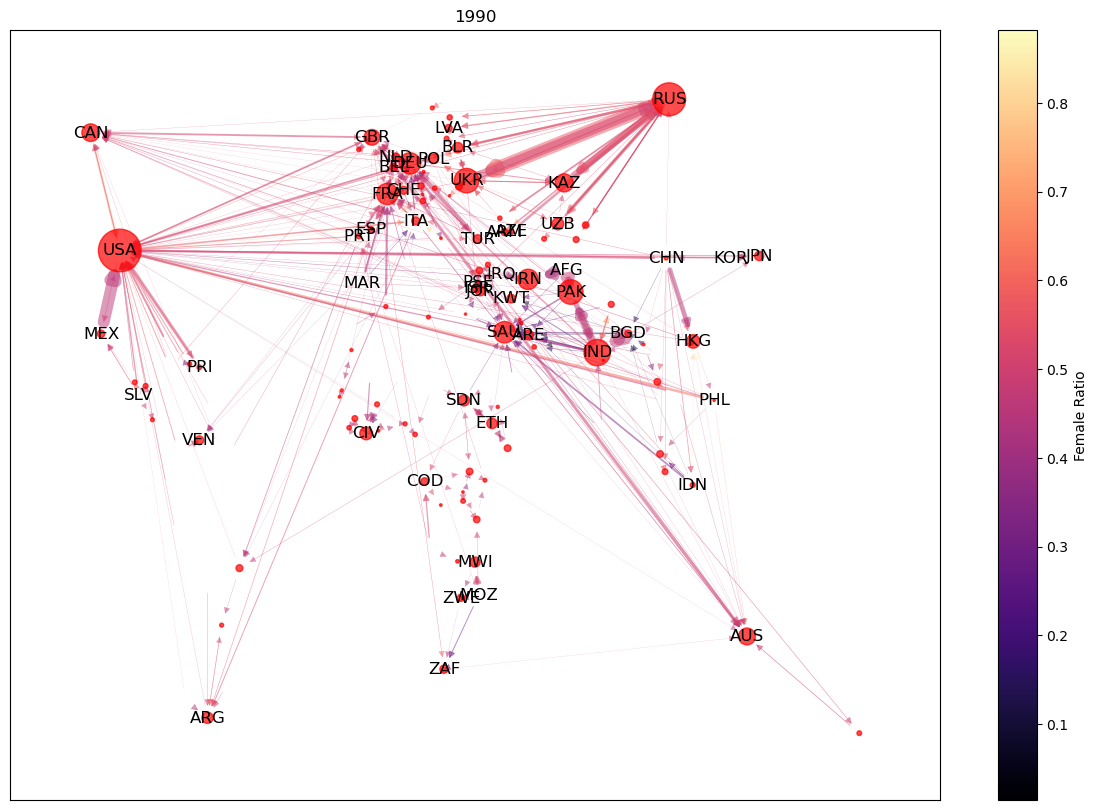

In [44]:
visualize_graph(graphs[0], nodes_df, '1990')

In [45]:
print(nx.info(graphs[0]))

DiGraph with 151 nodes and 408 edges


C:\Users\PA\AppData\Local\Temp\ipykernel_5320\3206093569.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(graphs[0]))


## 4. Converting the graph to unweighted

In [46]:
# Removing the weights from the first graph
for u, v, d in graphs[0].edges(data=True):
        d.clear()

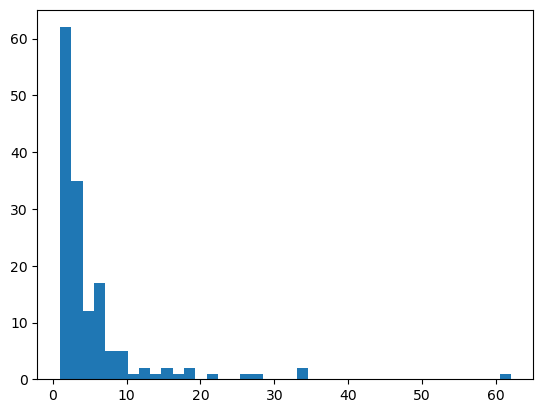

In [47]:
# plotting the degree distribution of first graph
degree_sequence = sorted([d for n, d in graphs[0].degree()], reverse=True)
plt.hist(degree_sequence, bins=40)
plt.show()

## 5- Community Detection (girvan_newman method for directed- unweighted graphs)

In [48]:
# Detecting communities in first graph
from networkx.algorithms import community
communities_generator = community.girvan_newman(graphs[0])
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))


[[0,
  1,
  2,
  8,
  9,
  11,
  12,
  13,
  15,
  16,
  18,
  19,
  22,
  24,
  26,
  28,
  31,
  35,
  37,
  41,
  42,
  43,
  44,
  45,
  46,
  50,
  52,
  53,
  55,
  56,
  62,
  63,
  64,
  65,
  68,
  73,
  74,
  78,
  79,
  80,
  83,
  88,
  91,
  92,
  94,
  95,
  97,
  98,
  99,
  100,
  101,
  103,
  104,
  105,
  106,
  107,
  108,
  111,
  112,
  113,
  114,
  115,
  116,
  118,
  120,
  123,
  124,
  127,
  130,
  133,
  139,
  140,
  141,
  144,
  145,
  147,
  148,
  154,
  155,
  157,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  169,
  170,
  180,
  181,
  182,
  185,
  187,
  188,
  191,
  193,
  194,
  195,
  197,
  199,
  200,
  201,
  202,
  203,
  204,
  209,
  210,
  211,
  212,
  216,
  217,
  218,
  220,
  222,
  223,
  225,
  226,
  228,
  229,
  231],
 [5, 33, 48, 58, 60, 67, 69, 109, 171, 190, 192, 196, 215, 219, 230],
 [21, 32, 36, 40, 51, 81, 89, 117, 126, 149, 150, 184, 206]]

In [49]:
# creating a list of all the communities in the first graph and storing them in a dictionary using the abbreviations of the states as keys
communities = []
for i in range(len(next_level_communities)):
    communities.append(list(next_level_communities[i]))  # Convert set to list
community_dict = {}
for i in range(len(communities)):
    for j in range(len(communities[i])):
        community_dict[communities[i][j]] = i

In [59]:
# printing the number of communities 
print(len(communities))

8


In [53]:
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(graphs[0])

print(communities)

8
[frozenset({65, 133, 199, 8, 73, 203, 209, 148, 88, 24, 28, 157, 220, 94, 160, 92, 222, 159, 35, 164, 166, 106, 42, 113, 50, 53, 56, 187, 62, 63}), frozenset({1, 191, 11, 83, 147, 22, 218, 91, 161, 98, 226, 165, 37, 101, 41, 105, 43, 44, 45, 116, 55, 185, 124, 127}), frozenset({193, 2, 197, 200, 74, 139, 204, 12, 80, 145, 210, 19, 211, 26, 31, 225, 163, 228, 104, 46, 52, 182, 188}), frozenset({0, 64, 194, 195, 201, 141, 15, 16, 144, 217, 154, 155, 97, 99, 100, 229, 107, 111, 115, 180, 118}), frozenset({68, 9, 202, 13, 79, 18, 212, 216, 95, 223, 162, 103, 167, 169, 170, 108, 112, 114, 120}), frozenset({192, 33, 67, 196, 69, 5, 230, 231, 171, 123, 109, 140, 48, 215, 58, 219, 60, 190}), frozenset({32, 36, 40, 206, 81, 51, 117, 149, 21, 184, 89, 150, 126}), frozenset({130, 181, 78})]


### 6. Visualization of communities using Greedy_modularity method

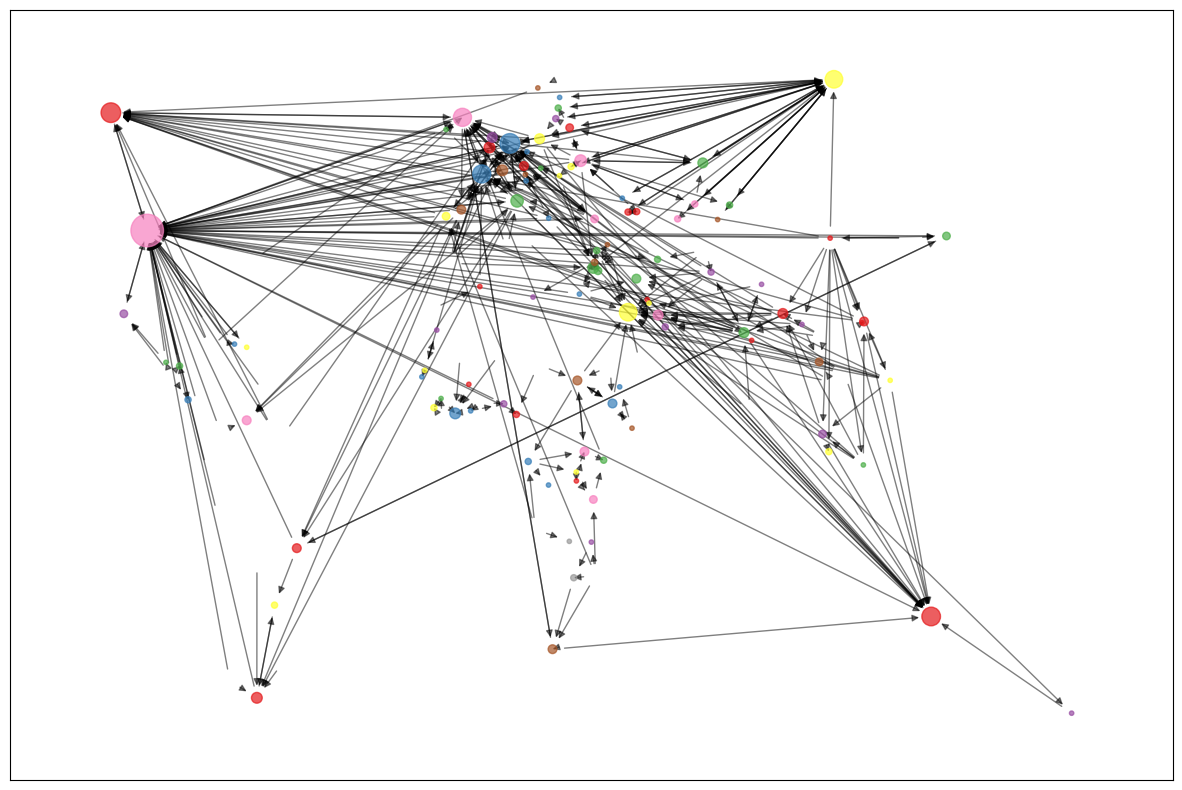

In [55]:
# visualizing the communities in each graph by coloring the nodes

communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(graphs[0])
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = i
node_sizes = [graphs[0].in_degree(n, weight='weight')*10 for n in graphs[0].nodes()]
node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graphs[0].nodes}
# adding labels to the nodes using the Abb column
labels = get_high_degree_labels(graphs[0], nodes_df)
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(graphs[0], node_positions, node_size=node_sizes, node_color=list(node_colors.values()), alpha=0.7, cmap=plt.cm.Set1, label=labels)
nx.draw_networkx_edges(graphs[0], node_positions, alpha=0.5)
plt.show()

In [57]:
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(graphs[0])
node_colors = {}
for i, community in enumerate(communities):
    print(i)
    print([nodes_df[nodes_df['Label'] == node]['Abb'].values[0] for node in community])

0
['SLV', 'MEX', 'SWE', 'ARG', 'FIN', 'THA', 'TTO', 'NIC', 'GTM', 'BOL', 'BRA', 'PAN', 'USA', 'HND', 'PER', 'HTI', 'URY', 'PRY', 'KHM', 'PRI', 'KOR', 'JPN', 'CHL', 'LAO', 'CRI', 'CUB', 'CZE', 'SVK', 'DOM', 'ECU']
1
['ALB', 'ZAF', 'AUS', 'GRC', 'NZL', 'BMU', 'GBR', 'GUY', 'PHL', 'IDN', 'VNM', 'QAT', 'CAN', 'IRL', 'CIN', 'JAM', 'CHN', 'HKG', 'MAC', 'LSO', 'CYP', 'SGP', 'MYS', 'MLT']
2
['ESP', 'DZA', 'SUR', 'CHE', 'FRA', 'MAR', 'MKD', 'AUT', 'DEU', 'NLD', 'TUN', 'BEL', 'TUR', 'BIH', 'BGR', 'VEN', 'PRT', 'ESH', 'ITA', 'COL', 'HRV', 'SRB', 'SVN']
3
['AFG', 'EGY', 'LKA', 'PSE', 'SYR', 'MMR', 'BHR', 'BGD', 'NPL', 'ARE', 'OMN', 'PAK', 'IND', 'IRN', 'IRQ', 'YEM', 'JOR', 'KWT', 'LBN', 'SAU', 'LBY']
4
['EST', 'ARM', 'TJK', 'AZE', 'GEO', 'BLR', 'TKM', 'UKR', 'HUN', 'UZB', 'POL', 'ISR', 'MDA', 'ROU', 'RUS', 'KAZ', 'KGZ', 'LVA', 'LTU']
5
['SSD', 'BDI', 'ERI', 'SDN', 'ETH', 'AGO', 'ZMB', 'ZWE', 'RWA', 'MWI', 'KEN', 'MOZ', 'COG', 'UGA', 'COD', 'TZA', 'DJI', 'SOM']
6
['BFA', 'CMR', 'TCD', 'TGO', 'GHA',

In [58]:
# computing the average clustering coefficient of each graph
print(nx.average_clustering(graphs[0]))
    

0.2529428843798187


In [34]:
# computing the degree centrality of each node in first graph
degree_centrality = nx.degree_centrality(graphs[0])
# sorting the nodes by degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
# printing the top 10 nodes with highest degree centrality by abbreviation
for node in sorted_degree_centrality[:10]:
    print(nodes_df[nodes_df['Label'] == node[0]]['Abb'].values[0])

USA
DEU
GBR
FRA
RUS
AUS
CAN
ITA
UKR
IND


In [35]:
# computing the degree centrality of each node in second graph
degree_centrality = nx.degree_centrality(graphs[1])
# sorting the nodes by degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
# printing the top 10 nodes with highest degree centrality by abbreviation
for node in sorted_degree_centrality[:10]:
    print(nodes_df[nodes_df['Label'] == node[0]]['Abb'].values[0])

USA
DEU
GBR
FRA
RUS
CAN
AUS
ITA
UKR
ESP


In [36]:
# computing the degree centrality of each node in third graph
degree_centrality = nx.degree_centrality(graphs[2])
# sorting the nodes by degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
# printing the top 10 nodes with highest degree centrality by abbreviation
for node in sorted_degree_centrality[:10]:
    print(nodes_df[nodes_df['Label'] == node[0]]['Abb'].values[0])

USA
DEU
GBR
FRA
CAN
AUS
RUS
ITA
ESP
UKR
